## Stratify Data

Problem: Labels sind imbalanced, wenn ich einfach k Klassen sample, dann kann es sein dass diese unterschiedlich viele beispiele pro klasse beinhalten und deswegen die Klassifikation mal besser und mal schlechter funktioniert. 

1. Möglichkeit: wiederhole das samplen der k Klassen für r random seeds und mittele die Ergebnisse. 
2. Möglichkeit: stratifiziere daten von anfang an, setze einen Schwellwert von z.B. 100 samples fest und werfe alle Klassen weg die weniger als 100 samples haben.  

- Tradeoff zwischen mehr few shot examples und steigender kontextlänge. Plot: wie steigt die kontextlänge gegeben der samples. Wie verändert sich die performance gegeben der kontextlänge auf x achse bzw. samples auf x achse
- Experiment: kontextlänge einsparen durch 
    - abkürzungen 
    - sonderzeichen weglassen
    - vorheriges paraphrasieren um zu kürzen (macht das sinn?)
    - dynamisches erstellen des promptes durch vorheriges RAG, es werden nur die 5 zutreffendsten klassen genommen und dazu dann gleiche anzahl an few shot examples vs. höhere anzahl an few shot examples aber gleiche gesamtkontextlänge (vorausgesetzt man hat genügend daten)

In [16]:
import sys
sys.path.append('..')
from src.llm_alex import Llama

import numpy
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import os


In [35]:
dataset = load_dataset("PolyAI/banking77")
train_data = dataset["train"]
test_data = dataset["test"]

#save data to a file

if not os.path.exists("../data"):
    os.makedirs("../data")
train_data.to_csv("../data/train_data.csv")
test_data.to_csv("../data/test_data.csv")

train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

Creating CSV from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 332.06ba/s]


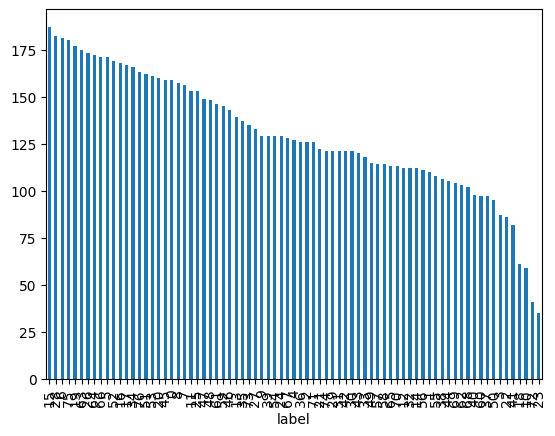

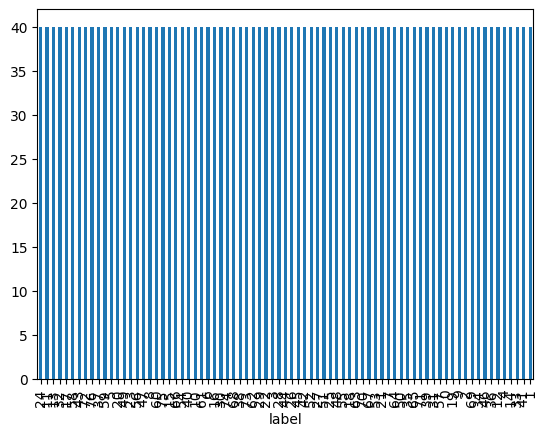

77
77


In [36]:
# check label distribution
train_data.label.value_counts().plot(kind='bar')
plt.show()

test_data.label.value_counts().plot(kind='bar')
plt.show()

print(len(train_data.label.unique()))  
print(len(test_data.label.unique()))

/var/folders/m6/4_p41bcx58jddx_zhmmqd_v00000gn/T/ipykernel_30530/881254091.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))


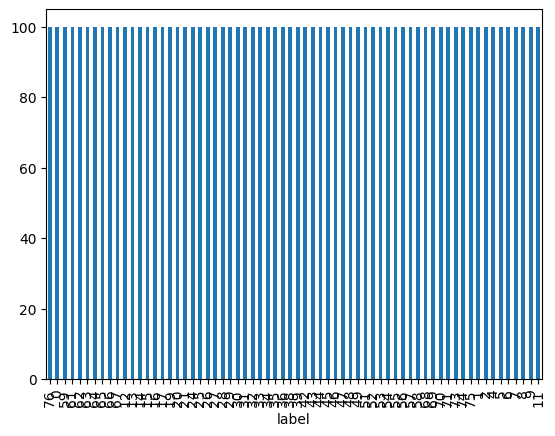

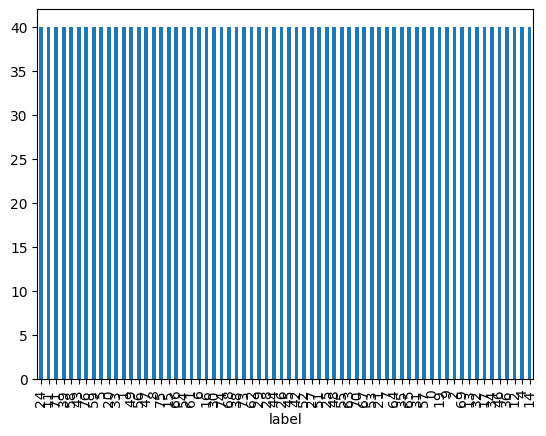

removed 0 classes


In [38]:
# stratify the data to 100 samples per class and remove classes with less than 100 samples
label_counts = train_data['label'].value_counts()
filtered_labels = label_counts[label_counts >= 100].index
train_data = train_data[train_data['label'].isin(filtered_labels)]
train_data = train_data.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))

#reflect the changes in the test data
test_data = test_data[test_data['label'].isin(filtered_labels)]

train_data.label.value_counts().plot(kind='bar')
plt.show()

test_data.label.value_counts().plot(kind='bar')
plt.show()

print(f"removed {len(label_counts) - len(filtered_labels)} classes")


In [58]:
#generate few shot prompt 
random_seed = 42
n_classes = 5
num_shots = 2

prompt = """Your task is to classify a given text into one of the following classes: 



"""
# sample n_classes with random seed
sampled_classes = train_data['label'].sample(n_classes, random_state=random_seed).values
train_data_sub = train_data[train_data['label'].isin(sampled_classes)]
test_data_sub = test_data[test_data['label'].isin(sampled_classes)]

def get_prompt_template(train_data_sub, num_shots):
    prompt_template = "Your task is to classify a given text into one of the following classes: \n\n"
    for label in train_data_sub.label.unique():
        prompt_template += f"Label: {label}\n"
        for i, row in train_data_sub[train_data_sub['label'] == label].sample(num_shots, random_state=random_seed).iterrows():
            prompt_template += f"Text: {row['text']}\n"
            #remove row from the dataframe
            train_data_sub = train_data_sub.drop(i)
        prompt_template += "\n"
    prompt_template += "Here is your text, please classify it into one of the above classes\n\n"
    return prompt_template




In [59]:
print(get_prompt_template(train_data_sub, num_shots))
print(f"Length of the prompt template: {len(get_prompt_template(train_data_sub, num_shots))} characters")

Your task is to classify a given text into one of the following classes: 

Label: 7
Text: What are the reasons a beneficiary would be denied?
Text: Hello - I'm on the app and trying to purchase crypto. It's not going through. What am I doing wrong?

Label: 19
Text: I don't understand why I was charged extra for withdrawing money?
Text: I used an ATM and wanted to know why I was charged an extra fee.

Label: 33
Text: I would like to change currency
Text: Will it be possible to change from USD to GBP with this App?

Label: 51
Text: A refund is taking too long.
Text: Transaction refund missing from my statement.

Label: 64
Text: Why did I get charged for a transfer?
Text: Are money transfers free?

Here is your text, please classify it into one of the above classes


Length of the prompt template: 774 characters
